In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import imageio
import joblib
from shutil import copy2, rmtree
from datetime import datetime, timedelta
from IPython.display import clear_output
from data_helpers import *
from constant import *
plt.style.use('seaborn-whitegrid')


In [2]:
data_path = r'C:\Users\jupol\Desktop\TensorTut\covid\legacyCovidMexico'
data_dir = os.listdir(data_path)

In [3]:
sufx_dict = {
    'Deaths': 'Casos_Diarios_Estado_Nacional_Defunciones_2020',
    'Confirmed': 'Casos_Diarios_Estado_Nacional_Confirmados_2020',
    'Suspicious': 'Casos_Diarios_Estado_Nacional_Sospechosos_2020',
    'Negatives': 'Casos_Diarios_Estado_Nacional_Negativos_2020',
    'Actives': 'Casos_Diarios_Estado_Nacional_Activos_2020'
}

In [19]:
def plot_single_discrete(index, plot_index, plot_data, state, file, dtype, max_day,trim):
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True
    plt.ylabel(f'Number of {dtype} Cases', fontsize=18)
    plt.ylim(0,max_day+(max_day*0.3))
    plt.xlim(trim,len(plot_index))
    plt.xticks(rotation=70)
    
    if type(state) == list:
        for ind, local in enumerate(state):
            join_names = join_list_names(state)
            plt.title(f'Daily {dtype} Cases for Covid19 in {join_names}', fontsize = 20)
            plt.bar(plot_index, plot_data[ind], label = f'{local}: {max(clean_nan(np.array(plot_data[ind])))}')
    else:
        plt.bar(plot_index,plot_data, label = f'Number of {dtype} Cases: {max(clean_nan(np.array(plot_data)))}')
        plt.title(f'Daily {dtype} Cases for Covid19 in {state}', fontsize = 20)
    plt.suptitle(f'{calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}', fontsize=22)
    plt.legend(loc=0,fontsize=20)
    
    if type(state) == list:
        join_names = join_list_names(state)
        plt.savefig(f'plots/{join_names}/discrete/{dtype}/{file[-12:-8]+"-"+file[-8:-6]+"-"+file[-6:-4]}.jpg')
    else:
        plt.savefig(f'plots/{state}/discrete/{dtype}/{file[-12:-8]+"-"+file[-8:-6]+"-"+file[-6:-4]}.jpg')

def plot_single_cummulative(index, plot_index, plot_data, state, file, dtype, max_cummulative,trim):
    
    if type(plot_data[0]) == list:
        join_names = join_list_names(state)
        cummulative_record = []
        for local in plot_data:
            cummulative_record.append(get_cummulative_record(local))
            
    else:
        cummulative_record = get_cummulative_record(plot_data)
    
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True
    if type(state) == list:
        plt.title(f'Cummulative register of {dtype} Cases by Covid19 in {join_names}', fontsize = 20)
    else:
        plt.title(f'Cummulative register of {dtype} Cases by Covid19 in {state}', fontsize = 20)
    plt.ylabel(f'Number of {dtype} Cases', fontsize=18)
    plt.ylim(0,max_cummulative+(max_cummulative*0.3))
    plt.xticks(rotation=70)
    plt.xlim(trim,len(plot_index))
    
    if type(state) == list:
        for ind, local in enumerate(state):
            plt.plot(plot_index,cummulative_record[ind], label=local+': '+str(max(clean_nan(cummulative_record[ind]))))
            plt.fill_between(plot_index, cummulative_record[ind], alpha=.2)
    else:
        plt.plot(plot_index,cummulative_record, label=dtype+': '+str(max(clean_nan(cummulative_record))))
        plt.fill_between(plot_index, cummulative_record, color='b', alpha=.2)
        
    plt.suptitle(f'{calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}', fontsize=22)
    plt.legend(loc=0, fontsize=18)
    
    if type(state) == list:
        plt.savefig(f'plots/{join_names}/cummulative/{dtype}/{file[-12:-8]+"-"+file[-8:-6]+"-"+file[-6:-4]}.jpg')
    else:
        plt.savefig(f'plots/{state}/cummulative/{dtype}/{file[-12:-8]+"-"+file[-8:-6]+"-"+file[-6:-4]}.jpg')

def plot_multi_discrete(index, plot_index, plot_data, days, dtypes, state, max_day,trim):
    
    today = calendar.month_name[int(days[0][-8:-6])]+'-'+ days[0][-6:-4]
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True

    plt.title(f'Daily {dtypes} Cases for Covid19 in {state}', fontsize = 20)
    plt.ylabel(f'Number of Cases', fontsize=18)
    plt.ylim(0,max_day+(max_day*0.3))
    plt.xlim(trim,len(plot_index))
    plt.xticks(rotation=70)
    for data in plot_data.keys():
        plt.bar(plot_index,plot_data[data], label = f'Number of {data} Cases: {max(clean_nan(np.array(plot_data[data])))}',alpha=0.4)
    plt.suptitle(f'{today}', fontsize=22)
    plt.legend(loc=0,fontsize=20)
    plt.savefig(f'plots/{state}/discrete/{dtypes}/{days[0][-12:-8]}-{days[0][-8:-6]}-{days[0][-6:-4]}.jpg')

def plot_multi_cummulative(index, plot_index, plot_data, days, dtypes, state, max_cummulative,trim):
    
    today = calendar.month_name[int(days[0][-8:-6])]+'-'+ days[0][-6:-4]
    cum_data = {key:[] for key in plot_data.keys()}
    
    for key in plot_data.keys():
    
        last_valid = int()
        for i in plot_data[key]:

            if len(cum_data[key]) == 0:
                if not np.isnan(i):
                    cum_data[key].append(i)
                    last_valid = i
                else:
                    cum_data[key].append(np.nan)
                    last_valid = 0
            else:
                if not np.isnan(i):
                    cum_data[key].append(i+last_valid)
                    last_valid += i

                else:
                    cum_data[key].append(np.nan)
            
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True
    
    plt.title(f'Cummulative register of {dtypes} Cases by Covid19 in {state}', fontsize = 20)
    plt.ylabel(f'Number of {dtypes} Cases', fontsize=18)
    plt.ylim(0,max_cummulative+(max_cummulative*0.3))
    plt.xticks(rotation=70)
    plt.xlim(trim,len(plot_index))
    for key in cum_data:
        plt.plot(plot_index,cum_data[key], label=key+': '+str(max(clean_nan(cum_data[key]))))
        plt.fill_between(plot_index, cum_data[key], alpha=.2)
        
    plt.suptitle(f'{calendar.month_name[int(days[0][-8:-6])]} {days[0][-6:-4]}', fontsize=22)
    plt.legend(loc=0, fontsize=18)
    
    plt.savefig(f'plots/{state}/cummulative/{dtypes}/{days[0][-12:-8]}-{days[0][-8:-6]}-{days[0][-6:-4]}.jpg')

In [20]:
def make_multi_state_plots(index, plot_index, state, file, dtype, max_day, max_cummulative,trim):
    
    join_names = join_list_names(state)
        
    if not os.path.exists(f'plots/{join_names}/cummulative/{dtype}'):
        os.makedirs(f'plots/{join_names}/cummulative/{dtype}')

    if not os.path.exists(f'plots/{join_names}/discrete/{dtype}'):
        os.makedirs(f'plots/{join_names}/discrete/{dtype}')
    
    data = []
    for local in state:
        
        local_data = pd.read_csv(os.path.join(data_path,file))
        local_data = local_data[local_data['nombre'] == local]
        plot_data = []

        for day in index:
            
            try:
                plot_data.append(local_data[str(day)[-11:-9]+str(day)[-15:-11]+str(day)[:4]].values[0])
            except:
                plot_data.append(np.nan)
        data.append(plot_data)
        
    plot_single_cummulative(index, plot_index, data, state, file, dtype, max_cummulative,trim) 
    
    plot_single_discrete(index, plot_index, data, state, file, dtype, max_day,trim)
    
    print(f'Plots of {dtype} for {join_names} ready for day: {calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}')
    
def make_plots(index, plot_index, state, file, dtype, max_day, max_cummulative,trim):
            
    if not os.path.exists(f'plots/{state}/cummulative/{dtype}'):
        os.makedirs(f'plots/{state}/cummulative/{dtype}')

    if not os.path.exists(f'plots/{state}/discrete/{dtype}'):
        os.makedirs(f'plots/{state}/discrete/{dtype}')
    
    data = pd.read_csv(os.path.join(data_path,file))
    data = data[data['nombre'] == state]
        
    plot_data = []
                       
    for day in index:
        try:
            plot_data.append(data[str(day)[-11:-9]+str(day)[-15:-11]+str(day)[:4]].values[0])
        except:
            plot_data.append(np.nan)
    
    plot_single_discrete(index, plot_index, plot_data, state, file, dtype, max_day,trim)
    
    plot_single_cummulative(index, plot_index, plot_data, state, file, dtype, max_cummulative,trim)    
    
    print(f'Plots of {dtype} ready for day: {calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}')

def make_multi_plots(index, plot_index, state, days, sufx_items, max_day, max_cummulative,trim,dtypes):
    
    if not os.path.exists(f'plots/{state}/cummulative/{dtypes}'):
        os.makedirs(f'plots/{state}/cummulative/{dtypes}')
        
    if not os.path.exists(f'plots/{state}/discrete/{dtypes}'):
        os.makedirs(f'plots/{state}/discrete/{dtypes}')
    
    data = [pd.read_csv(os.path.join(data_path,x)) for x in days]
    data = [x[x['nombre'] == state] for x in data]
        
    plot_data = {key:[] for key in sufx_items.keys()}
    
    
    
    for ind, key in enumerate(plot_data.keys()):
        for day in index:
            try:
                plot_data[key].append(data[ind][str(day)[-11:-9]+str(day)[-15:-11]+str(day)[:4]].values[0])
            except:
                plot_data[key].append(np.nan)
    
    plot_multi_discrete(index, plot_index, plot_data, days, dtypes, state, max_day,trim)
    plot_multi_cummulative(index, plot_index, plot_data, days, dtypes, state, max_cummulative,trim)
    print(f'Plots of {dtypes} ready for day: {calendar.month_name[int(days[0][-8:-6])]} {days[0][-6:-4]}')

In [29]:
def get_indexes(sufx, data_dir, state):

    newest_date = get_max_min(sufx, data_dir, 'max')
    oldest_date = get_max_min(sufx, data_dir, 'min')

    newest_date = pd.read_csv(os.path.join( data_path, sufx + str(newest_date)[-14:-12]+str(newest_date)[-11:-9]+'.csv') )
    oldest_date = pd.read_csv(os.path.join( data_path, sufx + str(oldest_date)[-14:-12]+str(oldest_date)[-11:-9]+'.csv') )
    
    max_day = get_max_day(state, newest_date)
    max_cummulative = get_max_cummulative(state, newest_date)
    
    index = pd.date_range(start= pd.to_datetime(oldest_date.columns[3], dayfirst=True), end = pd.to_datetime(newest_date.columns[-1], dayfirst=True))
    plot_index = [calendar.month_name[int(str(x)[5:-12])] + ' / ' + str(x)[8:-9]  for x in index]
        
    return index, plot_index, max_day, max_cummulative

def get_multi_indexes(files, data_dir, state, sufx_items):
    
    newest_date = max([get_max_min(sufx_items[sufx], data_dir, 'max') for sufx in sufx_items.keys()])
    oldest_date = min([get_max_min(sufx_items[sufx], data_dir, 'min') for sufx in sufx_items.keys()])
    
    longest_data_check = 0
    longest_data = ''
    max_day = 0
    max_cummulative = 0
    
    for dtype in files.keys():
        
        data_check = pd.read_csv(os.path.join( data_path, sufx_items[dtype] + str(newest_date)[-14:-12]+str(newest_date)[-11:-9]+'.csv'))
        max_discrete = max(data_check[data_check['nombre'] == state].values[0][3:])
        sum_cummulative = sum(data_check[data_check['nombre'] == state].values[0][3:])
        
        if len(data_check.columns[3:]) > longest_data_check:
            longest_data_check == len(data_check.columns[3:])
            longest_data = data_check[data_check['nombre'] == state]
            
        if  max_discrete > max_day:
            max_day = max_discrete
        if sum_cummulative > max_cummulative:
            max_cummulative = sum_cummulative
    
    index = pd.date_range(start= pd.to_datetime(longest_data.columns[3], dayfirst=True), end = pd.to_datetime(longest_data.columns[-1], dayfirst=True))
    plot_index = [calendar.month_name[int(str(x)[5:-12])] + ' / ' + str(x)[8:-9]  for x in index]
    
    return index, plot_index, max_day, max_cummulative

In [30]:
def make_animation(data_dir, dtype, state, trim=0):
    
    if type(dtype) == list :
        
        sufx_items = {key:sufx_dict[key] for key in dtype}
        
        dtypes_list = [x for x in sufx_items.keys()]
        dtypes=''
        for i in dtypes_list:
            dtypes += i+' '
        dtypes = dtypes[:-1]
        
        files = {}
        for key in sufx_items.keys():
            files[key] = [file for file in data_dir if file.startswith(sufx_items[key])]
        
        assert len(set([len(files[key]) for key in files.keys()])) == 1
        
        index, plot_index, max_day, max_cummulative = get_multi_indexes(files, data_dir, state, sufx_items)
        
        for instance in range(len(files[dtype[0]])):
            days = []
            for key in files.keys():
                days.append(files[key][instance])
            
            make_multi_plots(index, plot_index, state, days, sufx_items, max_day, max_cummulative,trim, dtypes)
            clear_output(wait=True)
        
        plots  = [x[:-4] for x in os.listdir(f'plots/{state}/cummulative/{dtypes}')]
        max_date = str(max(pd.to_datetime(plots)))[:10]
        
        make_mp4(state,dtypes,max_date)
        
        
    else:
        
        sufx = sufx_dict[dtype]
        index, plot_index, max_day, max_cummulative = get_indexes(sufx, data_dir, state)
        
        files = [file for file in data_dir if file.startswith(sufx)]
        
        if type(state)==list:
            
            for file in files:
                
                make_multi_state_plots(index, plot_index, state, file, dtype, max_day, max_cummulative,trim)
                clear_output(wait=True)
        else:
            
            for file in files:
                make_plots(index, plot_index, state, file, dtype, max_day, max_cummulative,trim)
                clear_output(wait=True)
        
        if type(state) == list:
            join_names = join_list_names(state)
            plots  = [x[:-4] for x in os.listdir(f'plots/{join_names}/cummulative/{dtype}')]
        else:
            plots  = [x[:-4] for x in os.listdir(f'plots/{state}/cummulative/{dtype}')]
        
        max_date = str(max(pd.to_datetime(plots)))[:10]
        
        make_mp4(state,dtype,max_date)

In [ ]:
make_animation(data_dir = data_dir,
               dtype     = 'Deaths',
               state    = 'OAXACA',
               trim=0)

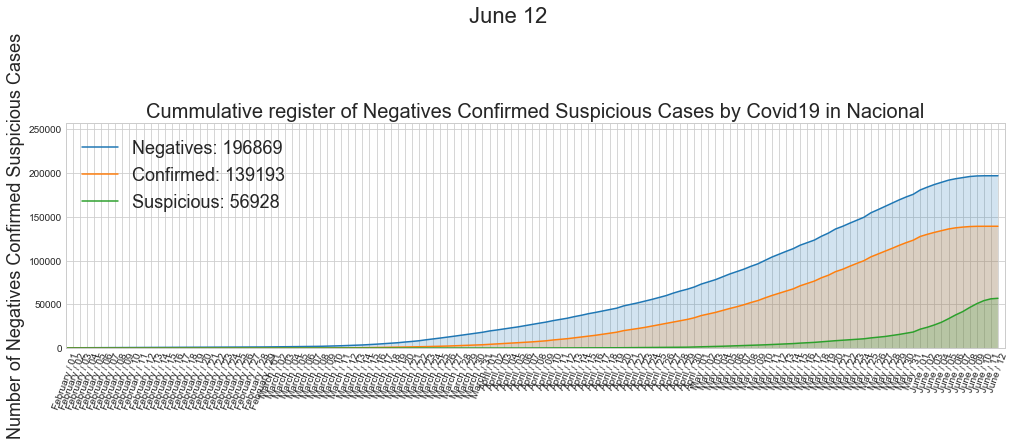

In [31]:
make_animation(data_dir = data_dir,
               dtype     = ['Negatives','Confirmed','Suspicious'],
               state    = 'Nacional',
               trim=10)

In [ ]:
make_animation(data_dir = data_dir,
               dtype     = 'Actives',
               state    = 'DISTRITO FEDERAL',
               trim=50)

In [ ]:
make_animation(data_dir = data_dir,
               dtype     = ['Confirmed','Actives'],
               state    = 'Nacional',
               trim=10)

Plots of Confirmed Actives ready for day: May 02


In [ ]:
make_animation(data_dir = data_dir,
               dtype     = ['Confirmed','Suspicious'],
               state    = 'Nacional',
               trim=10)

In [ ]:
make_animation(data_dir = data_dir,
               dtype     = ['Confirmed','Suspicious'],
               state    = 'OAXACA',
               trim=10)

In [ ]:
d_dir = r'C:\Users\jupol\Desktop\TensorTut\covid\pass'
pass_dir = os.listdir(r'C:\Users\jupol\Desktop\TensorTut\covid\pass')
dates_pass = {date[4:6]+'-'+date[2:4]+'-'+'20'+date[:2] : date for date in pass_dir}

In [ ]:
dtypes_states = {
    'Defunciones': 'Casos_Diarios_Estado_Nacional_Defunciones_2020',
    'Confirmados': 'Casos_Diarios_Estado_Nacional_Confirmados_2020',
    'Negativos'  : 'Casos_Diarios_Estado_Nacional_Negativos_2020',
    'Sospechosos': 'Casos_Diarios_Estado_Nacional_Sospechosos_2020',
    'Activos'    : 'Casos_Diarios_Estado_Nacional_Activos_2020'
}

In [ ]:
def create_data_from_patients_files(actives_window = 14):
    result = {}
    for state in cdns_states:
        result[state] = {}
        for dtype in dtypes_states.keys():

            result[state][dtype] = {} 
            base  = pd.read_csv(os.path.join(r'C:\Users\jupol\Desktop\TensorTut\covid\legacyCovidMexico', f'{dtypes_states[dtype]}0518.csv'))
            state_data = base[base['nombre'] == state]
            for today in dates_pass.keys():

                result[state][dtype][today] = []
                
                if dtype == 'Defunciones':

                    today_result = []

                    patients = change_df_names(pd.read_csv(os.path.join( d_dir, dates_pass[today] ), encoding='ANSI'))
                    if state != 'Nacional':
                        patients = patients[patients['treated_at'] == inverse_dict_for_name_states[state] ]
                    patients = patients[patients['day_of_death'] != '9999-99-99' ]
                    patients = patients[patients['result'] == 1]
                    patients = pd.to_datetime(patients['day_of_death'].copy())

                    if len(patients) == 0:
                        min_date = pd.to_datetime(state_data.columns[3],dayfirst=True)
                    else:
                        min_date = min(min(patients),pd.to_datetime(state_data.columns[3],dayfirst=True))

                    local_index = pd.date_range(start = min_date, end = pd.to_datetime(today, dayfirst=True))

                    for day in pd.to_datetime(local_index):
                        try:
                            today_result.append(list(patients).count(day))

                        except:
                            today_result.append(0)

                    result[state][dtype][today] = today_result
                    result[state][dtype][today+'_localindex'] = local_index
                    print(f' Done for: {state}-{dtype}-{today} ')
                    clear_output(wait=True)
                    
                if dtype == 'Confirmados':

                    today_result = []

                    patients = change_df_names(pd.read_csv(os.path.join( d_dir, dates_pass[today] ), encoding='ANSI'))
                    if state != 'Nacional':
                        patients = patients[patients['treated_at'] == inverse_dict_for_name_states[state] ]
                    patients = patients[patients['result'] == 1 ]
                    patients = pd.to_datetime(patients['onset_symptoms'].copy())

                    if len(patients) == 0:
                        min_date = pd.to_datetime(state_data.columns[3],dayfirst=True)
                    else:
                        min_date = min(min(patients),pd.to_datetime(state_data.columns[3],dayfirst=True))

                    local_index = pd.date_range(start = min_date, end = pd.to_datetime(today, dayfirst=True))

                    for day in pd.to_datetime(local_index):
                        try:
                            today_result.append(list(patients).count(day))

                        except:
                            today_result.append(0)

                    result[state][dtype][today] = today_result
                    result[state][dtype][today+'_localindex'] = local_index
                    print(f' Done for: {state}-{dtype}-{today} ')
                    clear_output(wait=True)
                    
                if dtype == 'Negativos':

                    today_result = []

                    patients = change_df_names(pd.read_csv(os.path.join( d_dir, dates_pass[today] ), encoding='ANSI'))
                    if state != 'Nacional':
                        patients = patients[patients['treated_at'] == inverse_dict_for_name_states[state] ]
                    patients = patients[patients['result'] == 2 ]
                    patients = pd.to_datetime(patients['onset_symptoms'].copy())
                    if len(patients) == 0:
                        min_date = pd.to_datetime(state_data.columns[3],dayfirst=True)
                    else:
                        min_date = min(min(patients),pd.to_datetime(state_data.columns[3],dayfirst=True))
                    local_index = pd.date_range(start = min_date, end = pd.to_datetime(today, dayfirst=True))

                    for day in pd.to_datetime(local_index):
                        try:
                            today_result.append(list(patients).count(day))

                        except:
                            today_result.append(0)

                    result[state][dtype][today] = today_result
                    result[state][dtype][today+'_localindex'] = local_index
                    print(f' Done for: {state}-{dtype}-{today} ')
                    clear_output(wait=True)

                if dtype == 'Sospechosos':

                    today_result = []

                    patients = change_df_names(pd.read_csv(os.path.join( d_dir, dates_pass[today] ), encoding='ANSI'))
                    if state != 'Nacional':
                        patients = patients[patients['treated_at'] == inverse_dict_for_name_states[state] ]
                    patients = patients[patients['result'] == 3 ]
                    patients = pd.to_datetime(patients['onset_symptoms'].copy())

                    if len(patients) == 0:
                        min_date = pd.to_datetime(state_data.columns[3],dayfirst=True)
                    else:
                        min_date = min(min(patients),pd.to_datetime(state_data.columns[3],dayfirst=True))

                    local_index = pd.date_range(start = min_date, end = pd.to_datetime(today, dayfirst=True))

                    for day in pd.to_datetime(local_index):
                        try:
                            today_result.append(list(patients).count(day))

                        except:
                            today_result.append(0)

                    result[state][dtype][today] = today_result
                    result[state][dtype][today+'_localindex'] = local_index
                    print(f' Done for: {state}-{dtype}-{today} ')
                    clear_output(wait=True)
                    
                if dtype == 'Activos':

                    today_result = []

                    patients = change_df_names(pd.read_csv(os.path.join( d_dir, dates_pass[today] ), encoding='ANSI'))
                    if state != 'Nacional':
                        patients = patients[patients['treated_at'] == inverse_dict_for_name_states[state] ]
                    patients = patients[patients['result'] == 1 ]
                    patients['onset_symptoms'] = pd.to_datetime(patients['onset_symptoms'])
                    
                    if len(patients) == 0:
                        min_date = pd.to_datetime(state_data.columns[3],dayfirst=True)
                    else:
                        min_date = min(min(patients['onset_symptoms']),pd.to_datetime(state_data.columns[3],dayfirst=True))

                    local_index = pd.date_range(start = min_date, end = pd.to_datetime(today, dayfirst=True))

                    active_patients = {key:0 for key in local_index}
                    
                    for ind, day_active in enumerate(patients['onset_symptoms']):
                        for _ in range(actives_window):
                            if day_active not in local_index:
                                break
                            elif patients['day_of_death'].iloc[ind] != '9999-99-99' and day_active > pd.to_datetime(patients['day_of_death'].iloc[ind]):
                                break
                            else:
                                active_patients[day_active] +=1
                                day_active = day_active + timedelta(days=1)
                    for date in local_index:
                        today_result.append(active_patients[date])
                    
                    result[state][dtype][today] = today_result
                    result[state][dtype][today+'_localindex'] = local_index
                    print(f' Done for: {state}-{dtype}-{today} ')
                    clear_output(wait=True)
                    
                    
    joblib.dump(result,'result_0612.pkl')
    for dtype in dtypes_states.keys():
        for date in dates_pass.keys():
            base  = pd.read_csv(os.path.join(r'C:\Users\jupol\Desktop\TensorTut\covid\legacyCovidMexico', f'{dtypes_states[dtype]}0518.csv'))
            data = {}
            for state in result.keys():

                data[state] = {}
                data[state] = result[state][dtype][date]

            max_len = max([len(data[x]) for x in result.keys()])

            for state in result.keys():
                if len(data[state]) != max_len:
                    data[state] = [0]*( max_len - len(data[state]) ) +data[state]

            today = pd.to_datetime(date, dayfirst=True)
            data = pd.DataFrame.from_dict(data).T
            index = pd.date_range(start=(today - timedelta(days=len(data.columns)-1) ), end = today)
            index=[str(date)[8:10]+'-'+str(date)[5:7]+'-'+str(date)[:4] for date in index]
            data.columns = index
            data['nombre'] = data.index
            data['poblacion'] = base['poblacion'].values.copy()
            data['cve_ent'] = base['cve_ent'].values.copy()
            order = ['cve_ent','poblacion', 'nombre']+index
            data = data[order]
            data = data.reset_index(drop = True)

            data.to_csv(f'faltantes/{dtypes_states[dtype]}{str(today)[:4]+str(today)[5:7]+str(today)[8:10]}.csv', encoding='ANSI',index=False)

In [ ]:
create_data_from_patients_files()

In [ ]:
ac = pd.read_csv(r'C:\Users\jupol\Desktop\TensorTut\covid\mex animations\faltantes\Casos_Diarios_Estado_Nacional_Activos_20200611.csv')

In [ ]:
ac = ac[ac['nombre']=='DISTRITO FEDERAL']

In [ ]:
plt.plot(ac.values[0][3:])